In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import json
import ast
import numpy as np
from embedding import load_graph_network
from train import fit_transform
from embedData import embedData
import torch
from scipy.sparse import identity, csr_matrix
from scipy import sparse
import re
import pandas as pd
import torch_geometric
from torch_scatter import scatter_add
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
import os

## loss curves

In [8]:
# 读取日志文件
with open('./output.log', 'r') as f:
    lines = f.readlines()

In [9]:
# 正则表达式匹配Epoch、Train Loss、Validation Loss
pattern = r'Epoch: (\d+), Train Loss: ([\d.]+), Validation Loss: ([\d.]+)'
epochs = []
train_loss = []
val_loss = []

for line in lines:
    match = re.search(pattern, line)
    if match:
        epochs.append(int(match.group(1)))
        train_loss.append(float(match.group(2)))
        val_loss.append(float(match.group(3)))

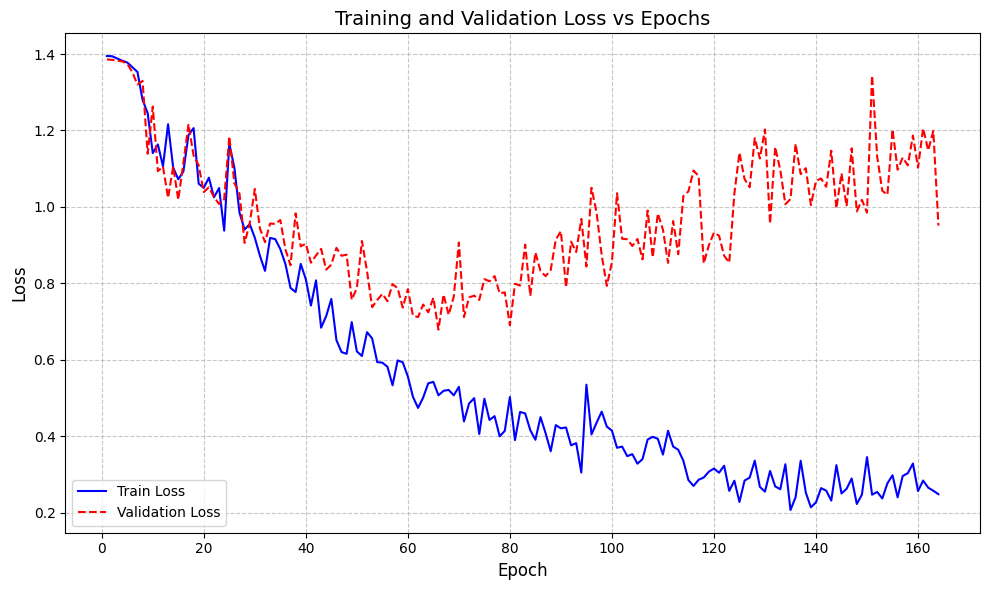

In [10]:
# 绘制曲线
plt.figure(figsize=(10, 6))

# 训练损失曲线（蓝色实线）
plt.plot(epochs, train_loss, '-b', label='Train Loss')

# 验证损失曲线（红色虚线）
plt.plot(epochs, val_loss, '--r', label='Validation Loss')

# 添加标题和坐标轴标签
plt.title('Training and Validation Loss vs Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 添加图例和网格
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 自动调整子图边距
plt.tight_layout()

# 保存图片（可选）
#plt.savefig('loss_curves.png', dpi=300)

# 显示图像
plt.show()

In [23]:
feature_matrix = np.load('../Data/UKB_feature_all_GAT_add_filtered_disGeNet_disease_disease_PPI_proteinTopEid_metaboliteTopEid.npy')

In [24]:
feature_matrix.shape

(49373, 512)

In [25]:
feature_matrix[200:202,0:20]

array([[ 0.05989955,  0.03276725,  0.04607746, -0.00403613, -0.00068263,
         0.1668962 ,  0.09198228,  0.05056943,  0.10521117, -0.00166432,
        -0.00033618,  0.0644499 ,  0.01460638,  0.00343931,  0.02391621,
         0.09416891,  0.02119602,  0.06044729,  0.0523751 , -0.00022215],
       [ 0.05464487,  0.04186152,  0.03126789, -0.00326686, -0.00112616,
         0.18048228,  0.06158229,  0.04531078,  0.1782947 , -0.00338941,
        -0.00028163,  0.06448168,  0.00528098, -0.00069697,  0.03001962,
         0.12437202,  0.01789629,  0.06448293,  0.05786491, -0.00259846]],
      dtype=float32)

In [26]:
print(np.max(feature_matrix))
print(np.min(feature_matrix))

0.84036034
-0.20513777


In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)
pca = PCA(n_components=2, random_state=42)
feature_matrix_pca = pca.fit_transform(feature_matrix_scaled)
print(f"PCA降维后形状: {feature_matrix_pca.shape}")
print(f"解释方差比例: {np.sum(pca.explained_variance_ratio_):.3f}")

PCA降维后形状: (49373, 2)
解释方差比例: 0.540


In [28]:
# 读取graph node names
with open('../Data/keys_add_filtered_disGeNet_disease_disease_PPI_proteinTopEid_metaboliteTopEid.json', 'r') as f:
    loaded_keys = json.load(f)

In [29]:
import re

def classify_element(element):
    # 正则表达式模式
    pattern_id = r'^\d+$'  # 全数字（病人ID）
    pattern_code = r'^[A-Z][A-Z\d]*$'  # 大写字母开头，后跟数字or大写字母(icd10)
    pattern_protein = r'^[a-z\d][a-z\d_]*$'
    
    # 分类判断
    if re.match(pattern_id, element):
        return 'eid'
    elif re.match(pattern_code, element):
        return 'icd10'
    elif re.match(pattern_protein, element):
        return 'protein'
    else:
        return 'metabolite'

In [30]:
keys_classification = [classify_element(key) for key in loaded_keys]

In [31]:
# 创建标签到颜色的映射
label_to_color = {
    'eid': 'blue',    # 病人ID用蓝色
    'icd10': 'red',           # 代码用红色
    'protein': 'green',
    'metabolite': 'orange'
}

# 将分类标签转换为对应的颜色列表
colors = [label_to_color[label] for label in keys_classification]

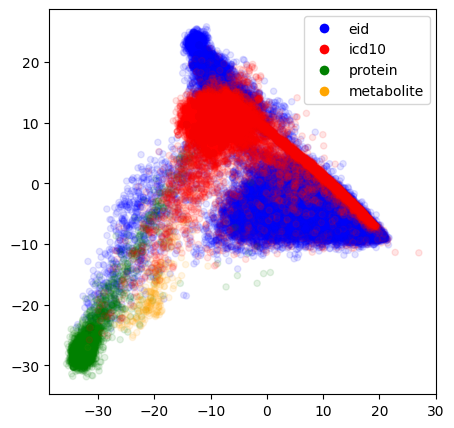

In [32]:
# 可视化结果 (使用PCA的前两个主成分)
plt.figure(figsize=(5, 5))
scatter = plt.scatter(feature_matrix_pca[:, 0], feature_matrix_pca[:, 1], 
                      c=colors, alpha=0.1, s=20)

# 添加图例（手动创建）
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='eid'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='icd10'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='protein'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='metabolite')
]
plt.legend(handles=legend_elements, loc='upper right')

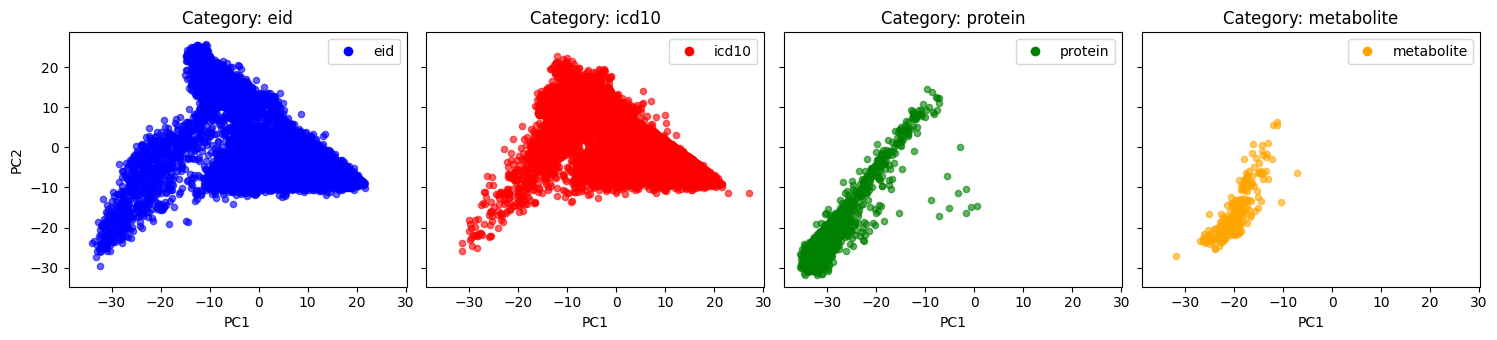

In [33]:
# 创建一个包含3个子图的画布
fig, axes = plt.subplots(1, 4, figsize=(15, 3.5), sharex=True, sharey=True)

# 按类别筛选数据并绘制
categories = ['eid', 'icd10', 'protein', 'metabolite']
category_colors = {'eid': 'blue', 'icd10': 'red', 'protein': 'green', 'metabolite': 'orange'}

for i, category in enumerate(categories):
    # 筛选当前类别的数据
    mask = np.array(keys_classification) == category
    pca_subset = feature_matrix_pca[mask]
    
    # 在对应的子图上绘制
    axes[i].scatter(pca_subset[:, 0], pca_subset[:, 1], 
                   c=category_colors[category], alpha=0.6, s=20)
    
    # 设置子图标题
    axes[i].set_title(f'Category: {category}')
    axes[i].set_xlabel('PC1')
    if i == 0:  # 只在第一个子图上设置ylabel
        axes[i].set_ylabel('PC2')
    
    # 添加图例
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=category_colors[category], markersize=8, label=category)
    ]
    axes[i].legend(handles=legend_elements, loc='upper right')

# 调整布局
plt.tight_layout()
plt.show()

In [34]:
import umap
reducer = umap.UMAP(n_components=2)
feature_matrix_umap = reducer.fit_transform(feature_matrix_pca)

/home/llma/anaconda3/envs/GAT/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


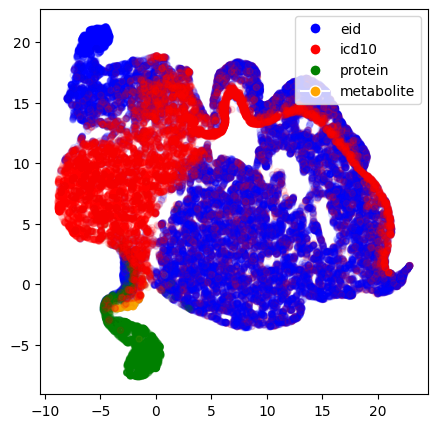

In [35]:
# 可视化结果 (使用PCA的前两个主成分)
plt.figure(figsize=(5, 5))
scatter = plt.scatter(feature_matrix_umap[:, 0], feature_matrix_umap[:, 1], 
                      c=colors, alpha=0.1, s=20)

# 添加图例（手动创建）
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='eid'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='icd10'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='protein'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='metabolite')
]
plt.legend(handles=legend_elements, loc='upper right')

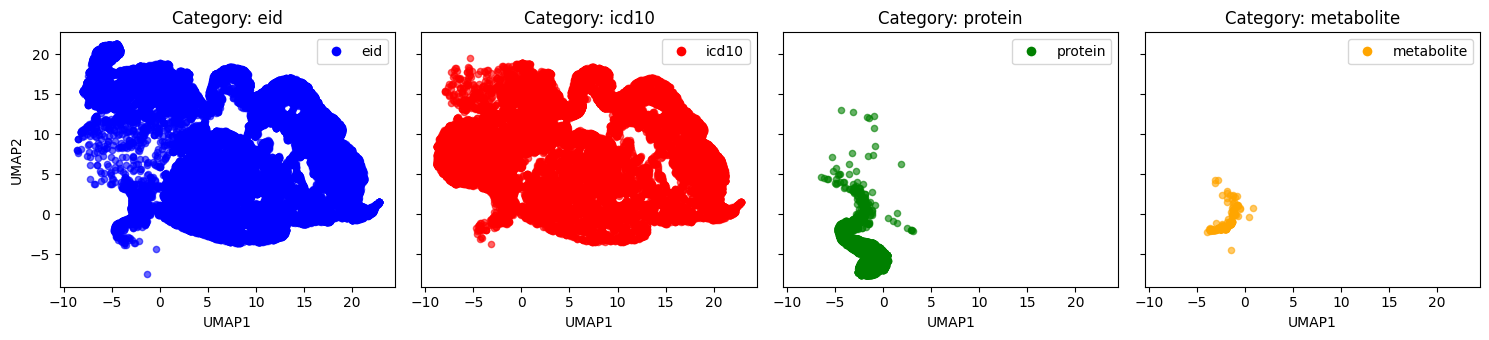

In [36]:
# 创建一个包含3个子图的画布
fig, axes = plt.subplots(1, 4, figsize=(15, 3.5), sharex=True, sharey=True)

# 按类别筛选数据并绘制
categories = ['eid', 'icd10', 'protein', 'metabolite']
category_colors = {'eid': 'blue', 'icd10': 'red', 'protein': 'green', 'metabolite': 'orange'}

for i, category in enumerate(categories):
    # 筛选当前类别的数据
    mask = np.array(keys_classification) == category
    umap_subset = feature_matrix_umap[mask]
    
    # 在对应的子图上绘制
    axes[i].scatter(umap_subset[:, 0], umap_subset[:, 1], 
                   c=category_colors[category], alpha=0.6, s=20)
    
    # 设置子图标题
    axes[i].set_title(f'Category: {category}')
    axes[i].set_xlabel('UMAP1')
    if i == 0:  # 只在第一个子图上设置ylabel
        axes[i].set_ylabel('UMAP2')
    
    # 添加图例
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=category_colors[category], markersize=8, label=category)
    ]
    axes[i].legend(handles=legend_elements, loc='upper right')

# 调整布局
plt.tight_layout()
plt.show()